# Define



Now that the initial hypothesis has been defined, we can focus on the following questions in the define phase:
- What matters most?
- What should I do to begin analysis?
- What is feasible?

The number 1 goal to keep in mind in the define phase is that we are defining a product around a user, not programming a user around a product.

#### Bank X Data Collection & Analysis

I am not at liberty to disclose any of the data or code used to pull this dataset together, nor show the dataset in this report. However, I will explain the thought process around what was done.

Data was gathered for customers who had a valid energy spend with Bank X accounted for, as well as their mortgage property details like year of constrction etc. This was then collated along with BER ratings. However the BER coverage was very poor and was supplemented with probabilities based on the SEAI BER external dataset found [here](https://ndber.seai.ie/BERResearchTool/ber/search.aspx). This however was still very imbalanced and hence I concluded a new approach was needed to be taken.

I can use the data of Bank X to gather statistics on the data (mean, min, max, std), and use this to create a new, 'ideal world' dataset of ficticious customers. Therefore in conclusion, I had to pivot in order to make the hypothesis still work. I was able to use the internal data sucessfully to provide for a theoretical sample.

This now sets up the body of work aligned with the define phase of this thesis.

Dwelling dimensions, orientation, 
ventilation, dwelling fabric, water heating, lighting, space heating, heating controls and 
fuel type influence the building energy rating and must all be considered when 
determining the actual rating and where potential improvements could be made.

In [1]:
# Read in libraries needed for analysis
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # Suppress all future warnings
pd.set_option('display.float_format', lambda x: '%.2f' % x) # Leaves all pandas calculations to 2 decimal places to avoid SN
import numpy as np
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns

/Users/oisinbrannock/.pyenv/versions/3.10.5/envs/masters_thesis/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Pull in the SEAI dataset to use for analysis
seai = pd.read_table( 
    '../data/external/BERPublicSearch/BERPublicsearch.txt'
    ,usecols=['CountyName', 'DwellingTypeDescr', 'Year_of_Construction', 'GroundFloorArea(sq m)', 'EnergyRating', 'BerRating', 'CO2Rating', 'TotalDeliveredEnergy', 'DateOfAssessment']
    ,encoding = 'Latin-1'
)

In [3]:
# High level overview of the dataset
seai

,CountyName,DwellingTypeDescr,Year_of_Construction,EnergyRating,BerRating,GroundFloorArea(sq m),CO2Rating,TotalDeliveredEnergy,DateOfAssessment
0,Co. Donegal,Detached house,1997,C2,180.01,171.19,45.53,25474.52,Oct 8 2010 12:00AM
1,Co. Kildare,Detached house,2010,B3,137.56,242.93,35.66,27654.47,Oct 19 2010 12:00AM
2,Co. Dublin,Semi-detached house,1999,C3,223.61,99.38,44.65,17000.04,Oct 9 2010 12:00AM
3,Dublin 11,Semi-detached house,1965,C2,196.99,138.41,37.83,22708.48,Oct 20 2010 12:00AM
4,Dublin 22,Semi-detached house,1985,D2,260.52,127.16,55.07,28182.86,Oct 21 2010 12:00AM
...,...,...,...,...,...,...,...,...,...
1043905,Co. Donegal,Detached house,1982,D2,282.58,214.18,70.89,52927.53,Jun 25 2022 12:00AM
1043906,Dublin 6,Mid-terrace house,1900,G,998.14,99.77,317.99,NaN,Jul 6 2022 12:00AM
1043907,Dublin 1,Mid-floor apartment,2021,A2,37.26,81.32,7.33,NaN,Dec 20 2021 12:00AM
1043908,Dublin 1,Mid-floor apartment,2022,A2,36.05,82.09,6.76,NaN,Jul 14 2022 12:00AM


In [4]:
seai.columns = seai.columns.str.replace('_', '')

In [5]:
# Taking a look at the SEAI dataset numerical columns
seai.describe()

,YearofConstruction,BerRating,GroundFloorArea(sq m),CO2Rating,TotalDeliveredEnergy
count,1043910.00,1043910.00,1043910.00,1043910.00,445800.00
mean,1983.79,234.55,114.01,54.56,24085.64
std,33.78,172.78,59.76,48.60,23306.38
min,1753.00,-158.42,5.47,-258.25,-3929.79
25%,1973.00,153.64,77.92,32.46,14844.80
50%,1997.00,207.08,100.30,46.25,21027.03
75%,2005.00,282.32,133.71,65.13,29315.55
max,2104.00,56423.71,3546.11,18417.10,5431169.68


In [6]:
# Check the datatypes for each column and determine if they are correct or not
seai.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1043910 entries, 0 to 1043909
Data columns (total 9 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   CountyName             1043910 non-null  object 
 1   DwellingTypeDescr      1043910 non-null  object 
 2   YearofConstruction     1043910 non-null  int64  
 3   EnergyRating           1043910 non-null  object 
 4   BerRating              1043910 non-null  float64
 5   GroundFloorArea(sq m)  1043910 non-null  float64
 6   CO2Rating              1043910 non-null  float64
 7   TotalDeliveredEnergy   445800 non-null   float64
 8   DateOfAssessment       1043910 non-null  object 
dtypes: float64(4), int64(1), object(4)
memory usage: 71.7+ MB


In [7]:
# Create a pandas profile report
profile = ProfileReport(seai, title="SEAI Data Report", explorative=True)

In [8]:
# Output the report to a html file to view
#profile.to_file("../reports/seai_profile_report.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 241.48it/s]


A few issues have arisen based on the initial observation of the data above:
- The dataset overview shows that the `CountyName` column has 'Co.' with each county and Dublin is split into numerical districts. Both need to be removed.
    - Done
- The description report shows the max year of construction is 2104. The max needs to be amended to be 2022.
    - Done
- The description report shows we have 57.3% missing values for `TotalDeliveredEnergy` column. This will need to be dropped at a minimum.
    - Done
- The description report shows that the min for `BerRating`, `CO2Rating` and `TotalDeliveredEnergy` are negative. This could be bad data or indication of a good BER rating. Needs to be investigated and dealt with.
    - Done
- The `EnergyRating` column is an object, it should be an ordered factor.
    - Done
- The `DateOfAssessment` column is an object, it should be a datetime object.
    - Done
- Make sure date column is sensible after conversion
    - Done
- There are duplicates being accounted for on some entries that must be removed.
    - Done

Note that I am not worried about the very high BerRating and CO2Rating maxiumums as they make sense when the data is examined.

In [9]:
# Removal of 'Co.' and numerical items from CountyName column
seai['CountyName'] = seai['CountyName'].str.replace('Co. ', '') # Removes all occurrences of Co.
seai['CountyName'] = seai['CountyName'].str.replace('City', '') # Removes all occurrences of City
seai['CountyName'] = seai['CountyName'].str.replace('\d+', '') # Removes all digits
seai['CountyName'] = seai['CountyName'].str.replace('Dublin W', 'Dublin') # Removes occurence of W after Dublin
seai['CountyName'] = seai['CountyName'].str.strip() # Removes any blankspace left after cleaning


In [10]:
# Checking out the column to see if changes have worked
print(seai['CountyName'].unique())
# Printing some lines between the two results for clarity
print('--------------------------------------------------------------------------------------------------------')
print('--------------------------------------------------------------------------------------------------------')
# Checking to see if the length is 26 (Number of counties in Republic of Ireland)
print(len(seai['CountyName'].unique()))

['Donegal' 'Kildare' 'Dublin' 'Limerick' 'Kerry' 'Kilkenny' 'Cork'
 'Wexford' 'Carlow' 'Galway' 'Louth' 'Offaly' 'Sligo' 'Wicklow' 'Clare'
 'Tipperary' 'Monaghan' 'Mayo' 'Laois' 'Westmeath' 'Roscommon' 'Meath'
 'Leitrim' 'Cavan' 'Waterford' 'Longford']
--------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------
26


---

<AxesSubplot:xlabel='YearofConstruction', ylabel='Count'>

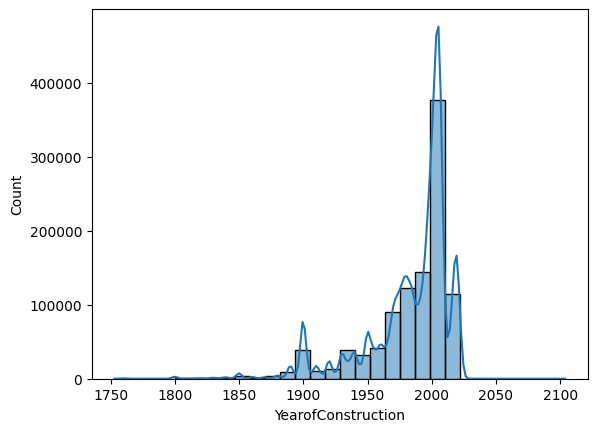

In [11]:
# Defining the statistics from Bank X data
sns.histplot(data=seai
            ,x='YearofConstruction'
            ,bins=30
            ,kde=True)

We can clearly see from above 2104 as a year is a once off error and can be removed

In [12]:
# Removal of bad year entry in data
seai = seai[seai['YearofConstruction'] <= 2022]

<AxesSubplot:xlabel='YearofConstruction', ylabel='Count'>

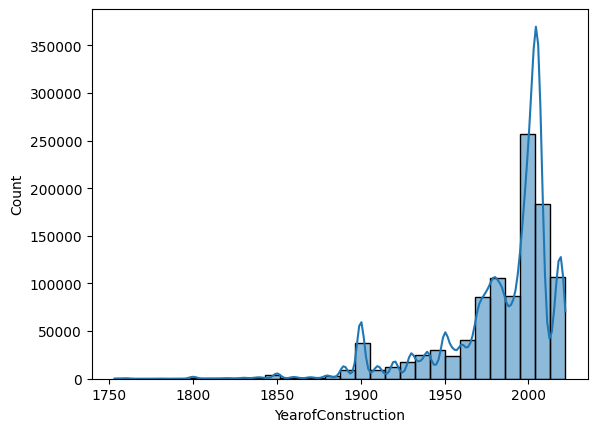

In [13]:
# Checking distributions again to check if this has worked.
sns.histplot(data=seai
            ,x='YearofConstruction'
            ,bins=30
            ,kde=True)

---

In [14]:
# Removal of missing data majority column
# seai = seai.drop('TotalDeliveredEnergy', axis=1)

---

In [15]:
# Checking out the distribution of values where we have negative in the 2 columns.
seai[['EnergyRating', 'CO2Rating']][(seai[['BerRating']] < 0).all(1) | 
                                    (seai[['CO2Rating']] < 0).all(1)].groupby('EnergyRating').count()

,CO2Rating
EnergyRating,
A1,167
A2,12
A3,12
B1,8
B2,8
B3,5
C1,6
C2,4
C3,1


Interestingly we have people who have lower bounds of energy ratings but still negative CO2 emissions somehow. Perhaps these people have solar panelling but their house rating is simply just poorer. 

The majority of houses with negative emissions are A1 rated which makes sense to what I would have thought the cause to be if these values were not poor data.

I will remove any below a B2 rating as I do not see logically other than solar panelling how this would occur. Regardless these people will skew the data and as such need to be accounted for.

In [16]:
# Identify all entries that qualify for removal as above and save them to a new dataframe
seai_to_drop = seai[seai['EnergyRating'].map(lambda x: x in ['B2', 'B3', 'C1', 'C2', 'C3'])][(seai[['BerRating']] < 0).all(1) | 
                                                                                             (seai[['CO2Rating']] < 0).all(1)
                                                                                            ]
# Drop these index entries from our original dataframe
seai = seai.drop(seai_to_drop.index)
# Delete the now redundant index dataframe
del(seai_to_drop)

/var/folders/f2/h4nbcthd4cld5t6fzd1x3jg40000gn/T/ipykernel_16928/1009298007.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  seai_to_drop = seai[seai['EnergyRating'].map(lambda x: x in ['B2', 'B3', 'C1', 'C2', 'C3'])][(seai[['BerRating']] < 0).all(1) |


In [17]:
# Check to see if these entries were dropped correctly. Should produce 0 rows
seai[seai['EnergyRating'].map(lambda x: x in ['B2', 'B3', 'C1', 'C2', 'C3'])][(seai[['BerRating']] < 0).all(1) | 
                                    (seai[['CO2Rating']] < 0).all(1)]

/var/folders/f2/h4nbcthd4cld5t6fzd1x3jg40000gn/T/ipykernel_16928/2974966041.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  seai[seai['EnergyRating'].map(lambda x: x in ['B2', 'B3', 'C1', 'C2', 'C3'])][(seai[['BerRating']] < 0).all(1) |


,CountyName,DwellingTypeDescr,YearofConstruction,EnergyRating,BerRating,GroundFloorArea(sq m),CO2Rating,TotalDeliveredEnergy,DateOfAssessment


---

In [18]:
# Remove any blank space
seai['EnergyRating'] = seai['EnergyRating'].str.strip()
# Changing the datatype of the EnergyRating column
seai['EnergyRating'] = seai['EnergyRating'].astype('category')
# Reorder categories in order of how good they are descending
seai['EnergyRating'] = seai['EnergyRating'].cat.reorder_categories(['A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'C1', 'C2', 'C3', 'D1', 'D2', 'E1', 'E2', 'F', 'G'])

In [19]:
# Checking the work above is correct
seai['EnergyRating'].unique()

['C2', 'B3', 'C3', 'D2', 'D1', ..., 'B2', 'B1', 'A3', 'A2', 'A1']
Length: 15
Categories (15, object): ['A1', 'A2', 'A3', 'B1', ..., 'E1', 'E2', 'F', 'G']

---

In [20]:
# Remove redundant time aspect of date column - regex used to remove 12:00AM from end of all rows
seai['DateOfAssessment'] = seai['DateOfAssessment'].str.replace(r'12:00AM$', '')
# Convert from string to datetime. Change any nonsense values to NaT
seai['DateOfAssessment'] = pd.to_datetime(seai['DateOfAssessment'], errors='coerce')

In [21]:
seai['DateOfAssessment'].describe()

count                 1043878
unique                   5280
top       2019-10-31 00:00:00
freq                      662
first     2000-01-22 00:00:00
last      2109-09-23 00:00:00
Name: DateOfAssessment, dtype: object

We still have nonsense date values so we will drop these 

In [22]:
# Drop any values above 30th June 2022
seai = seai[~(seai['DateOfAssessment'] > '2022-06-30')]
seai = seai[~seai['DateOfAssessment'].isnull()]

---

In [23]:
# Drop all duplicates in the dataset and keep the first entry of each
seai = seai.drop_duplicates(keep='first')

---
---

In [24]:
# Reset index so it is not included in report putput
seai.reset_index(drop=True, inplace=True)

In [25]:
# Create a pandas profile report
profile_optimised = ProfileReport(seai, title="SEAI Data Cleaned Report", explorative=True)

In [26]:
# Output the report to a html file to view
#profile_optimised.to_file("../reports/seai_cleaned_profile_report.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 286.12it/s]


The new generated report shows we have:
- No duplicate rows
- No missing values
- All fixes made above implemented correctly

---

<AxesSubplot:xlabel='EnergyRating', ylabel='count'>

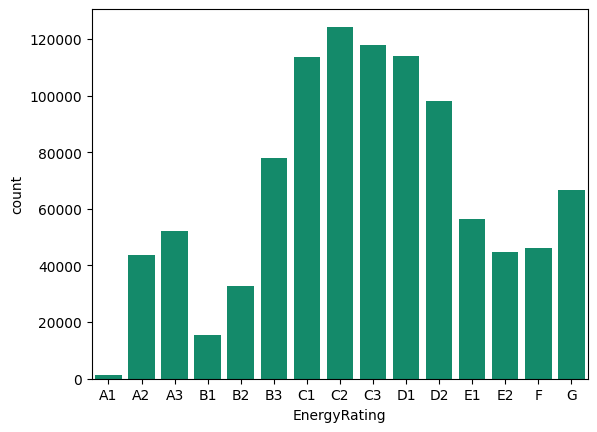

In [27]:
sns.countplot(
             data=seai
            ,x='EnergyRating'
            ,order=['A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'C1', 'C2', 'C3', 'D1', 'D2', 'E1', 'E2', 'F', 'G']
            ,color='#009E73')

---

In [28]:
# Taking a look at the SEAI dataset numerical columns
seai

,CountyName,DwellingTypeDescr,YearofConstruction,EnergyRating,BerRating,GroundFloorArea(sq m),CO2Rating,TotalDeliveredEnergy,DateOfAssessment
0,Donegal,Detached house,1997,C2,180.01,171.19,45.53,25474.52,2010-10-08
1,Kildare,Detached house,2010,B3,137.56,242.93,35.66,27654.47,2010-10-19
2,Dublin,Semi-detached house,1999,C3,223.61,99.38,44.65,17000.04,2010-10-09
3,Dublin,Semi-detached house,1965,C2,196.99,138.41,37.83,22708.48,2010-10-20
4,Dublin,Semi-detached house,1985,D2,260.52,127.16,55.07,28182.86,2010-10-21
...,...,...,...,...,...,...,...,...,...
1005531,Dublin,Mid-terrace house,2005,C1,158.91,148.17,29.42,NaN,2022-06-28
1005532,Dublin,Mid-floor apartment,2022,A2,39.01,74.90,7.35,NaN,2022-06-27
1005533,Dublin,Top-floor apartment,2022,A2,46.90,77.00,8.82,NaN,2022-06-28
1005534,Donegal,Detached house,1982,D2,282.58,214.18,70.89,52927.53,2022-06-25


I want to model out the `TotalDeliveredEnergy` missing values to account for them using a regression based imputation

Before I go down that route, is there an easier way to do this?
- Could I impute based on the features I already have and use the mode/mean?
    - kNN imputation could work well here.
        - For this to work, we need to first change any string or categorical features into numerical format. This can be done using One-Hot-Encoding
        - We also need to normalise our data as kNN is a distance based metric.

In [29]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [30]:
# https://stackoverflow.com/a/52935270/5923619
# One Hot Encodes our categorical feature and binds it to the original dataset
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    return(res)

In [31]:
# One Hot Encode all of our categorical features
seai_copy_encoded = encode_and_bind(seai, 'CountyName')
seai_copy_encoded = encode_and_bind(seai_copy_encoded, 'DwellingTypeDescr')
seai_copy_encoded = encode_and_bind(seai_copy_encoded, 'EnergyRating')

In [32]:
# Dropping the unencoded columns for now
seai_copy_encoded = seai_copy_encoded.drop(['CountyName', 'DwellingTypeDescr', 'EnergyRating','DateOfAssessment'], axis = 1)

In [33]:
# Moving target column to the very last
new_cols = [col for col in seai_copy_encoded.columns if col != 'TotalDeliveredEnergy'] + ['TotalDeliveredEnergy']
seai_copy_encoded = seai_copy_encoded[new_cols]

In [34]:
# Min Max Scaling our dataset so kNN will work
scaler = MinMaxScaler()
seai_copy_encoded = pd.DataFrame(scaler.fit_transform(seai_copy_encoded), columns = seai_copy_encoded.columns)

The issue with what I am doing above is the kNN Imputer is only able to see 100k values at a time. This may be biased for each split as it cannot select based on the entire dataset. The ordering may even be a factor in this. Therefore I need a more computationally efficient algorithm

MissForest is a machine learning-based imputation technique. It uses a Random Forest algorithm to do the task. It is based on an iterative approach, and at each iteration the generated imputations are better.
Unlike KNN, MissForest doesn’t care about the scale of the data and doesn’t require tuning. It is easier to use out of the box, but that doesn’t mean the results will be better.
Advantages: It doesn’t require data preparation, as the Random Forest algorithm can determine which features are important for imputation. It doesn’t require tuning, and can handle categorical variables.
Disadvantages: It can be computationally expensive when working with large datasets.

In [35]:
# MissForest does not work without this fix on latest version of Scikit-Learn
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

In [36]:
from missingpy import MissForest
# Make an instance and perform the imputation
imputer = MissForest()
data_imputed = imputer.fit_transform(seai_copy_encoded)
data_imputed = pd.DataFrame(data=data_imputed, columns=seai_copy_encoded.columns)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


In [37]:
data_imputed

,YearofConstruction,BerRating,GroundFloorArea(sq m),CO2Rating,CountyName_Carlow,CountyName_Cavan,CountyName_Clare,CountyName_Cork,CountyName_Donegal,CountyName_Dublin,...,EnergyRating_C1,EnergyRating_C2,EnergyRating_C3,EnergyRating_D1,EnergyRating_D2,EnergyRating_E1,EnergyRating_E2,EnergyRating_F,EnergyRating_G,TotalDeliveredEnergy
0,0.91,0.01,0.05,0.01,0.00,0.00,0.00,0.00,1.00,0.00,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
1,0.96,0.01,0.07,0.01,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
2,0.91,0.01,0.03,0.01,0.00,0.00,0.00,0.00,0.00,1.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.79,0.01,0.04,0.01,0.00,0.00,0.00,0.00,0.00,1.00,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.86,0.01,0.03,0.01,0.00,0.00,0.00,0.00,0.00,1.00,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005531,0.94,0.01,0.04,0.01,0.00,0.00,0.00,0.00,0.00,1.00,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1005532,1.00,0.00,0.02,0.01,0.00,0.00,0.00,0.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1005533,1.00,0.00,0.02,0.01,0.00,0.00,0.00,0.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1005534,0.85,0.01,0.06,0.01,0.00,0.00,0.00,0.00,1.00,0.00,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.01


In [38]:
# Reverse Normalisation
unscaled = scaler.inverse_transform(data_imputed)

In [39]:
# Convert the array back to a dataframe with the original column names 
unscaled = pd.DataFrame(data=unscaled, columns=seai_copy_encoded.columns)

In [40]:
# https://stackoverflow.com/a/62085741/5923619
# Function to remove the one hot encoding after the imputation has been completed
def undummify(df, prefix_sep="_"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df

In [42]:
# Perform the reverse encoding
seai_cleaned = undummify(unscaled)

In [ ]:
# Check out the dataframe to ensure it was a success
seai_cleaned

In [45]:
# Make sure the year is not a float
seai_cleaned['YearofConstruction'] = seai_cleaned['YearofConstruction'].astype('int')